In [6]:
# Code edited from Dario's cost-of-chemical-space project 

import pandas as pd
import sqlite3
from functools import reduce
from itertools import islice
import pickle
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [5]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rcParams.update({'font.size': 18})

## Read in Reaxys database

SQLite access to locally downloaded Reaxys database (from Dario)

In [8]:
conn = sqlite3.connect("C:\\Users\\group\\Desktop\\full_molecules.db")
first_line = pd.read_sql_query("""SELECT * FROM molecules LIMIT 1""", conn)
conn.close()
print(first_line)

           smiles reaxys_id                          name  formula       MW  \
0  CC(I)CC1CCCCN1      1267  2-(2-Iodo-propyl)-piperidine  C8H16IN  253.126   

    CAS bioactivity availability as_product                    InChI_key  \
0  None           0            0          0  LADXKDUENYZGKB-UHFFFAOYSA-N   

  markush_count n_references ma_publication_year  entry_date update_date  \
0             0            6                1970  1988/06/27  2022/03/24   

  as_reagent as_reagent_reactions  
0       None                 None  


In [4]:
conn = sqlite3.connect("C:\\Users\\group\\Desktop\\full_molecules.db")
df = pd.read_sql_query("""SELECT smiles, InChI_key, reaxys_id, n_references, name, as_reagent, as_product FROM molecules""", conn)
conn.close()
print(df)

## Read in SureChemBL database

Test: Read in a subset of the SureChemBL database to find smiles which can be linked with Reaxys

Eventual goal - apply this over entire SureChemBL database

In [13]:
#Test a subset of SureChemBL
fp = "G:\\Shared drives\\SureChemBL_Patents\\Cpd_Data\SureChEMBL_20141001_1.txt"
surechembl_df = pd.read_csv(fp, sep='\t')
print(surechembl_df)

          SureChEMBL_ID                                             SMILES  \
0              SCHEMBL4                   C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O   
1              SCHEMBL9  O=C(O)\C=C/C(=O)O.CCOC(=O)[C@H](CCC1=CC=CC=C1)...   
2             SCHEMBL10  OC(=O)C=CC(O)=O.CCOC(=O)[C@H](CCC1=CC=CC=C1)N[...   
3             SCHEMBL11  CC\C=C\C1=NC(Cl)=C(C=O)N1CC1=CC=C(C=C1)C1=C(C=...   
4             SCHEMBL12  CC=CCC1=NC(Cl)=C(C=O)N1CC1=CC=C(C=C1)C1=C(C=CC...   
...                 ...                                                ...   
7157446  SCHEMBL7999995             CCCCC1=CC2=CC=CC=C2C(OCC(CCN)N(C)C)=N1   
7157447  SCHEMBL7999997  CCCCCCCCCCCCCCCC(CC)NC(C(C)C)C1=CC2=C(C=CC(C)(...   
7157448  SCHEMBL7999998  COC1=C(F)C(C)=NC(=N1)N1C[C@H]2C(=O)N(C)C(=N)N[...   
7157449  SCHEMBL7999999  CCCCCCOC1=C(OC(C)C)C(=O)N(CCCCCC)C2=C1C=CC(NC(...   
7157450  SCHEMBL8000000  COC1=C2C3=C(NC(=O)C2=CC=C1)SC(CN1CCC[C@@H]1C(F...   

                                                     InChI  \
0

In [14]:
surechembl_df = surechembl_df.rename(columns={"InChIKey":"InChI_key"})

          SureChEMBL_ID                                             SMILES  \
0              SCHEMBL4                   C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O   
1              SCHEMBL9  O=C(O)\C=C/C(=O)O.CCOC(=O)[C@H](CCC1=CC=CC=C1)...   
2             SCHEMBL10  OC(=O)C=CC(O)=O.CCOC(=O)[C@H](CCC1=CC=CC=C1)N[...   
3             SCHEMBL11  CC\C=C\C1=NC(Cl)=C(C=O)N1CC1=CC=C(C=C1)C1=C(C=...   
4             SCHEMBL12  CC=CCC1=NC(Cl)=C(C=O)N1CC1=CC=C(C=C1)C1=C(C=CC...   
...                 ...                                                ...   
7157446  SCHEMBL7999995             CCCCC1=CC2=CC=CC=C2C(OCC(CCN)N(C)C)=N1   
7157447  SCHEMBL7999997  CCCCCCCCCCCCCCCC(CC)NC(C(C)C)C1=CC2=C(C=CC(C)(...   
7157448  SCHEMBL7999998  COC1=C(F)C(C)=NC(=N1)N1C[C@H]2C(=O)N(C)C(=N)N[...   
7157449  SCHEMBL7999999  CCCCCCOC1=C(OC(C)C)C(=O)N(CCCCCC)C2=C1C=CC(NC(...   
7157450  SCHEMBL8000000  COC1=C2C3=C(NC(=O)C2=CC=C1)SC(CN1CCC[C@@H]1C(F...   

                                                     InChI  \
0

## SureChemBL/Reaxys analysis

Combine & analyze the two databases

In [56]:
dataframes = [df, surechembl_df]
combined_df = reduce(lambda left, right: pd.merge(left, right, on=["InChI_key"], how="inner"), dataframes)
print(combined_df.head())

             smiles                    InChI_key reaxys_id n_references  \
0    CC(O)CN1CCCCC1  UCASFSAKVJTSET-UHFFFAOYSA-N      1268           56   
1     CCCC1CCCCN1CC  WIIWOZRNGAHZGW-UHFFFAOYSA-N      1272            1   
2  CC1CN(C)CC(C)N1C  XVJRVYONDJGSLX-UHFFFAOYSA-N      1273           16   
3      OCCCN1CCCCC1  PLRXAFVBCHEMGD-UHFFFAOYSA-N      1275          208   
4    CC1CCCN(CCO)C1  CAMLJDZKPYMXOK-UHFFFAOYSA-N      1278            4   

                                  name as_reagent as_product   SureChEMBL_ID  \
0         1-Piperidin-1-yl-propan-2-ol       None         14   SCHEMBL862327   
1          1-Ethyl-2-propyl-piperidine       None          0  SCHEMBL1275000   
2       1,2,4,6-Tetramethyl-piperazine       None          0    SCHEMBL81109   
3                                   na       None         16     SCHEMBL9400   
4  2-(3-Methyl-piperidin-1-yl)-ethanol       None          2    SCHEMBL13003   

             SMILES                                              InC

In [57]:
#Try to add degrees to this combined dataframe...
fp = "G:\\Shared drives\\SureChemBL_Patents\\Degrees\\Months\\IdDegrees\\id_degrees_2019-12.p"
id_degrees = pickle.load(file=open(fp, "rb"))
print(type(id_degrees))

print(list(islice(id_degrees.items(), 10)))

<class 'dict'>
[('SCHEMBL18007617', 801), ('SCHEMBL19276898', 162), ('SCHEMBL24290', 917), ('SCHEMBL2945027', 938), ('SCHEMBL31363', 603), ('SCHEMBL2127406', 533), ('SCHEMBL79611', 364), ('SCHEMBL343756', 104), ('SCHEMBL12205249', 359), ('SCHEMBL1725161', 52)]


In [58]:
id_degree_df = pd.DataFrame(list(id_degrees.items()), columns=["SureChEMBL_ID", "degree"])
print(id_degree_df)

         SureChEMBL_ID  degree
0      SCHEMBL18007617     801
1      SCHEMBL19276898     162
2         SCHEMBL24290     917
3       SCHEMBL2945027     938
4         SCHEMBL31363     603
...                ...     ...
93695    SCHEMBL290836     411
93696     SCHEMBL20977     238
93697  SCHEMBL21599701    1458
93698  SCHEMBL21602312    1060
93699  SCHEMBL21600585     617

[93700 rows x 2 columns]


In [59]:
dataframes = [combined_df, id_degree_df]
full_df = reduce(lambda left, right: pd.merge(left, right, on=["SureChEMBL_ID"], how="inner"), dataframes)
print(full_df.columns)

Index(['smiles', 'InChI_key', 'reaxys_id', 'n_references', 'name',
       'as_reagent', 'as_product', 'SureChEMBL_ID', 'SMILES', 'InChI',
       'degree'],
      dtype='object')


In [70]:
full_df["n_references"] = pd.to_numeric(full_df["n_references"])
full_df["as_reagent"] = pd.to_numeric(full_df["as_reagent"])
full_df["as_product"] = pd.to_numeric(full_df["as_product"])

Text(0, 0.5, 'N_Products')

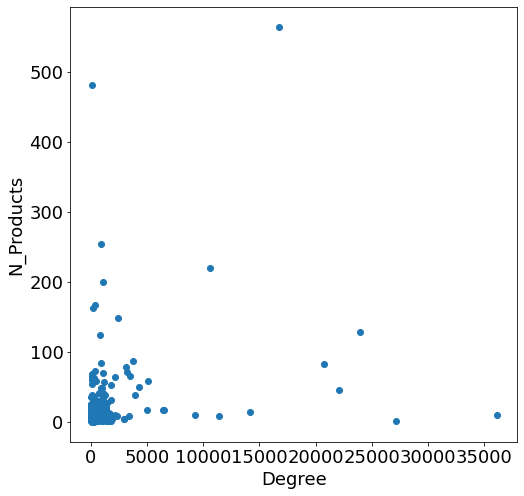

In [75]:
plt.figure(figsize=(8,8))
plt.scatter(full_df.degree, full_df.as_product)

plt.xlabel("Degree")
plt.ylabel("N_Products")

Text(0, 0.5, 'N_Products')

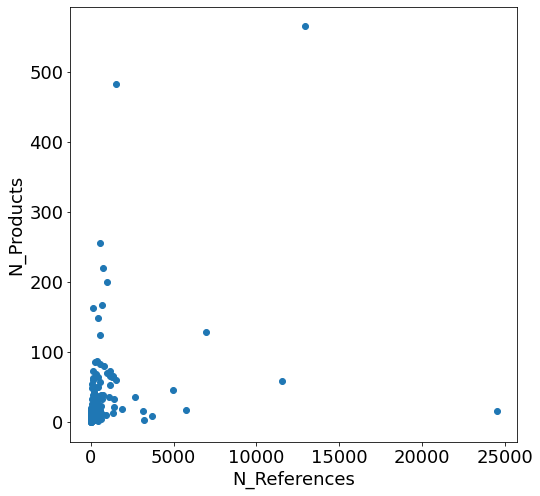

In [74]:
plt.figure(figsize=(8,8))
plt.scatter(full_df.n_references, full_df.as_product)

plt.xlabel("N_References")
plt.ylabel("N_Products")

## Random Reaxys MA 

Open Q: what was the criteria for selecting these? What kind of metadata do I have?

In [3]:
#Get MA values
def get_MA(fp):
    """ Get AssemblyGo MA value

    Args:
        fp (str): filepath to a particular .txt AssemblyGo output file

    Returns:
        label (str): label of the compound which was analzyed
        MA (int): assemblyGo MA value
        time (float): how much time it took to complete each MA run
    """
    with open(fp) as f:
        lines = f.readlines()

    try:
        #molfile will be the last element in 0th line
        label = lines[0].split()[-1].split("/")[-1].split(".")[0]

        #MA will be last elemnt in -2nd line (will be an int)
        MA = int(lines[-2].split()[-1])

        time = float(lines[-1].split()[-1])
        
        return label, MA, time

    except:
        return None, None, None



In [8]:
#Get list of MA values, create a pandas dataframe of label/MA values
fp = "Data/AssemblyValues/ReaxysRandom_Done/ReaxysRandom_Done/"
result_files = [x for x in os.listdir(fp) if x.endswith(".txt")]

results = []
for f in tqdm(result_files):
    label, MA, time = get_MA(fp + f)
    results.append({"label": label, "MA": MA, "time": time})
    

100%|██████████| 79873/79873 [00:12<00:00, 6287.48it/s]


In [9]:
results_df = pd.DataFrame(results)
print(results_df)

          label    MA        time
0      10757719  17.0  300.914381
1       5380159  29.0  299.824537
2      31671536  29.0  299.933365
3      10975189  12.0  106.447870
4      34942307  19.0  300.748215
...         ...   ...         ...
79868  24689744  19.0  300.139830
79869  27396869  15.0    1.379475
79870   7386348   9.0    0.110438
79871    819170  20.0  300.043927
79872  26189414  12.0   75.268518

[79873 rows x 3 columns]


63.0


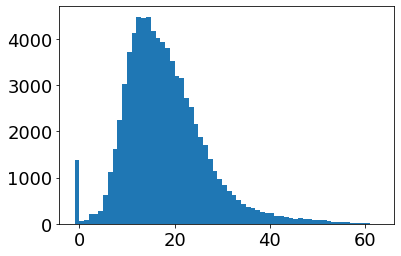

In [17]:
max_value = max(results_df["MA"])
print(max_value)

plt.hist(results_df["MA"], bins=int(max_value + 1)) #+1 to account for -1 values, probably should be removed

plt.show()